# Install required libraries (if not already installed)

In [39]:
!pip install transformers datasets torch nltk torchvision bitsandbytes torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install --upgrade accelerate>=0.26.0
!pip install transformers[torch] rouge-score matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu121
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   - -------------------------------------- 0.3/8.1 MB ? eta -:--:--
   --- ------------------------------------ 0.8/8.1 MB 3.4 MB/s eta 0:00:03
   --------- ------------------------------ 1.8/8.1 MB 3.7 MB/s eta 0:00:02
   ------------- -------------------------- 2.6/8.1 MB 3.9 MB/s eta 0:00:02
   ------------------ --------------------- 3.7/8.1 MB 4.1 MB/s eta 0:00:02
   ----------------------- ---------------- 4.7/8.1 MB 4.3 MB/s eta 0:00:01
   ----------------------------- ---------- 6.0/8.1 MB 4.5 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.1 MB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ----------------------- ---------------- 1.3/2.2 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.

# Import necessary libraries

In [1]:
import torch
from transformers import BartForConditionalGeneration, BartTokenizer
from datasets import load_dataset
import nltk

# Download sentence tokenizer

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shouv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load the tokenizer and model

In [3]:
model_name = 'facebook/bart-base'
tokenizer = BartTokenizer.from_pretrained(model_name)
model = BartForConditionalGeneration.from_pretrained(model_name)

print("Model and Tokenizer Loaded Successfully!")

Model and Tokenizer Loaded Successfully!


# Define a Function for Abstractive Summarization

In [4]:
def generate_summary(text, max_input=1024, max_output=200):
    """
    Generate abstractive summary using BART model.
    
    Args:
        text (str): The legal text to summarize.
        max_input (int): Max token length for input text.
        max_output (int): Max token length for summary output.

    Returns:
        str: The generated summary.
    """
    # Tokenize input text
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=max_input, truncation=True).to(model.device)
    
    # Generate summary
    summary_ids = model.generate(inputs, max_length=max_output, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
    
    # Decode and return summary
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Test the function

In [5]:
sample_text = "In a landmark case, the Supreme Court ruled that freedom of speech does not include the right to incite violence. \
This decision overturned previous rulings and set a new precedent in constitutional law."

print("Generated Summary:", generate_summary(sample_text))

Generated Summary: summarize: In a landmark case, the Supreme Court ruled that freedom of speech does not include the right to incite violence. This decision overturned previous rulings and set a new precedent in constitutional law. The Supreme Court affirmed the First Amendment's First Amendment rights.


# Load a legal dataset (example: 'legal_trec' from Hugging Face datasets)

In [6]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0") 
# Rename columns to match "text" and "labels"
dataset = dataset.rename_columns({"article": "text", "highlights": "labels"})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 11490
    })
})


# Extract legal texts and their summaries

In [7]:
dataset["train"] = dataset["train"].select(range(50000))  # Use 100 samples for training
dataset["validation"] = dataset["validation"].select(range(10000))  # 20 for validation
dataset["test"] = dataset["test"].select(range(10000))  # 20 for testing

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 50000
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 10000
    })
})


In [8]:
print(f"CUDA version: {torch.version.cuda}")

CUDA version: 12.1


# Fine-Tune BART on Legal Documents

In [10]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, AutoModel
import torch
import time
from torch.utils.data import DataLoader
torch._dynamo.config.suppress_errors = True

# def preprocess_data(examples):
#     # Tokenize inputs
#     model_inputs = tokenizer(
#         examples["text"],
#         max_length=1024,
#         truncation=True,
#         padding="max_length"  # Changed from False to max_length
#     )
    
#     # Tokenize targets with the tokenizer
#     with tokenizer.as_target_tokenizer():
#         labels = tokenizer(
#             examples["labels"],
#             max_length=200,
#             truncation=True,
#             padding="max_length"  # Changed from False to max_length
#         )
    
#     model_inputs["labels"] = labels["input_ids"]
#     return model_inputs

def preprocess_data(examples):
    # Tokenize inputs and truncate/pad
    inputs = tokenizer(
        examples["text"],
        max_length=1024,
        truncation=True,
        padding="max_length"
    )
    
    # Tokenize targets (summaries)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["labels"],
            max_length=200,
            truncation=True,
            padding="max_length"
        )
    
    return {
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
        "labels": labels["input_ids"]
    }
    
# Tokenize dataset
# tokenized_dataset = dataset.map(
#     preprocess_data,
#     batched=True,
#     remove_columns=["text", "labels"],
#     load_from_cache_file=True
# )

tokenized_dataset = dataset.map(
    preprocess_data,
    batched=True,
    remove_columns=["text", "labels", "id"],  # Remove all non-tensor columns
    load_from_cache_file=False
)


# Training Arguments Optimized for Your Setup
training_args = Seq2SeqTrainingArguments(
    output_dir="./bart_legal_summarizer_2",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,
    generation_max_length=128,
    generation_num_beams=1,
    num_train_epochs=4,
    learning_rate=3e-5,
    weight_decay=0.01,
    fp16=True,
    optim="adamw_bnb_8bit",
    gradient_checkpointing=True,
    dataloader_pin_memory=True,
    dataloader_num_workers=8,
    logging_steps=50,
    save_total_limit=2,
    predict_with_generate=True,
    remove_unused_columns=False  # Add this line
)

# Dynamic Padding Collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True  # Enable dynamic padding
)

# Enable Flash Attention & Memory-Efficient Training
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False
torch.cuda.empty_cache()

# Optionally, create a custom DataLoader for training if you want to experiment with prefetch_factor
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    batch_size=training_args.per_device_train_batch_size,
    num_workers=12,
    prefetch_factor=4,
    pin_memory=True,
    collate_fn=data_collator  # Use the data collator for dynamic padding
)
# Create Trainer using the custom DataLoader for training (if needed)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Start Training
trainer.train()

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

C:\Users\Shouv\miniconda3\envs\legal_summarizer\lib\site-packages\transformers\tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

C:\Users\Shouv\miniconda3\envs\legal_summarizer\lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Shouv\AppData\Local\Temp\ipykernel_20700\2317988994.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,10.825100,10.825063
2,10.825100,10.825063
3,10.825100,10.825063
4,10.825100,10.825063


C:\Users\Shouv\miniconda3\envs\legal_summarizer\lib\site-packages\transformers\modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=25000, training_loss=10.825067138671875, metrics={'train_runtime': 15956.4543, 'train_samples_per_second': 12.534, 'train_steps_per_second': 1.567, 'total_flos': 1.21947291648e+17, 'train_loss': 10.825067138671875, 'epoch': 4.0})

# Load the fine tuned model

In [14]:
from transformers import BartForConditionalGeneration, BartTokenizer
import torch

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM


# Path to your saved model
model_path = "./bart_legal_summarizer/checkpoint-5000"  # Replace with your actual path

# Load tokenizer and model
tokenizer_1 = BartTokenizer.from_pretrained(model_path)
model_1 = BartForConditionalGeneration.from_pretrained(model_path)


tokenizer_2 = AutoTokenizer.from_pretrained("easwar03/bart-base-legal-summarizer")
model_2 = AutoModelForSeq2SeqLM.from_pretrained("easwar03/bart-base-legal-summarizer")


# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model_1.to(device)
model_2.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): BartScaledWordEmbedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_lay

In [21]:
def summarize_text(text, max_input_length=1024, max_output_length=200):
    # Tokenize input
    inputs = tokenizer_1(
        "summarize: " + text,  # Add task prefix (optional, depends on your training)
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    ).to(device)
    
    # Generate summary
    summary_ids = model_1.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_output_length,
        num_beams=20,          # Beam search for better quality
        early_stopping=True,  # Stop early if plausible summary is found
        length_penalty=2.0    # Encourage longer summaries (adjust as needed)
    )
    
    # Decode and return
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

def summarize_text_2(text, max_input_length=1024, max_output_length=200):
    # Tokenize input
    inputs = tokenizer_2(
        "summarize: " + text,  # Add task prefix (optional, depends on your training)
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    ).to(device)
    
    # Generate summary
    summary_ids = model_2.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=max_output_length,
        num_beams=20,          # Beam search for better quality
        early_stopping=True,  # Stop early if plausible summary is found
        length_penalty=2.0    # Encourage longer summaries (adjust as needed)
    )
    
    # Decode and return
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [22]:
from nltk.tokenize import word_tokenize

def count_words(text):
    """Count words in a text string."""
    return len(word_tokenize(text))

def calculate_summarization_ratio(original_text, summary_text):
    """Calculate compression ratio of summary vs original text."""
    original_length = count_words(original_text)
    summary_length = count_words(summary_text)
    ratio = summary_length / original_length
    return ratio

In [23]:
# # Example legal text
# legal_text = """
# The general principles governing the exercise of the discretion to award indemnity costs after rejection by an 
# unsuccessful party of a so called Calderbank letter were set out in the judgment of the Full Court in Black v 
# Lipovac [1998] FCA 699 ; (1998) 217 ALR 386. In summary those principles are: 1. Mere refusal of a "Calderbank offer" 
# does not itself warrant an order for indemnity costs. In this connection it may be noted that Jessup J in Dais Studio 
# Pty Ltd v Bullet Creative Pty Ltd [2008] FCA 42 said that (at [6]): if the rejection of such an offer is to ground a 
# claim for indemnity costs, it must be by reason of some circumstance other than that the offer happened to comply with 
# """

# # Generate summary using your trained model
# summary_1 = summarize_text(legal_text)
# summary_2 = summarize_text_2(legal_text)
# summary_3 = generate_summary(legal_text)

# # Calculate ratio
# ratio_1 = calculate_summarization_ratio(legal_text, summary_1)
# ratio_2 = calculate_summarization_ratio(legal_text, summary_2)
# ratio_3 = calculate_summarization_ratio(legal_text, summary_3)
# print(f"Summarization Ratio: {ratio_1:.2f} (Summary is {ratio_1*100:.1f}% the length of the original)")
# print("Generated Summary:", summary_1)
# print(f"Summarization Ratio: {ratio_2:.2f} (Summary is {ratio_2*100:.1f}% the length of the original)")
# print("Generated Summary 2:", summary_2)
# print(f"Summarization Ratio: {ratio_3:.2f} (Summary is {ratio_3*100:.1f}% the length of the original)")
# print("Generated Summary 3:", summary_3)

from rouge_score import rouge_scorer

def calculate_rouge(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

In [24]:
# # Example legal text (input)
# legal_text = """
# The general principles governing the exercise of the discretion to award indemnity costs after rejection by an 
# unsuccessful party of a so called Calderbank letter were set out in the judgment of the Full Court in Black v 
# Lipovac [1998] FCA 699 ; (1998) 217 ALR 386. In summary those principles are: 1. Mere refusal of a "Calderbank offer" 
# does not itself warrant an order for indemnity costs. In this connection it may be noted that Jessup J in Dais Studio 
# Pty Ltd v Bullet Creative Pty Ltd [2008] FCA 42 said that (at [6]): if the rejection of such an offer is to ground a 
# claim for indemnity costs, it must be by reason of some circumstance other than that the offer happened to comply with 
# """

# # Generate summaries using different models
# summary_1 = summarize_text(legal_text)  # Your trained model
# summary_2 = summarize_text_2(legal_text)  # Baseline model
# summary_3 = generate_summary(legal_text)  # Another model for comparison

# # Assume we have a human-written reference summary
# reference_summary = "The principles for indemnity costs after rejecting a Calderbank letter were outlined in Black v Lipovac (1998), stating that mere refusal isn't enough to justify indemnity costs."

# # Calculate ROUGE scores
# rouge_scores_1 = calculate_rouge(reference_summary, summary_1)
# rouge_scores_2 = calculate_rouge(reference_summary, summary_2)
# rouge_scores_3 = calculate_rouge(reference_summary, summary_3)

# # Display metrics
# def print_rouge_scores(scores, model_name):
#     print(f"\n{model_name} ROUGE Scores:")
#     print(f"ROUGE-1: {scores['rouge1'].precision:.2f}, {scores['rouge1'].recall:.2f}, {scores['rouge1'].fmeasure:.2f}")
#     print(f"ROUGE-2: {scores['rouge2'].precision:.2f}, {scores['rouge2'].recall:.2f}, {scores['rouge2'].fmeasure:.2f}")
#     print(f"ROUGE-L: {scores['rougeL'].precision:.2f}, {scores['rougeL'].recall:.2f}, {scores['rougeL'].fmeasure:.2f}")

# print_rouge_scores(rouge_scores_1, "Your Trained Model")
# print_rouge_scores(rouge_scores_2, "Baseline Model")
# print_rouge_scores(rouge_scores_3, "Other Model")


In [25]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Extracting F1 scores for each model
# rouge1_f1 = [rouge_scores_1['rouge1'].fmeasure, rouge_scores_2['rouge1'].fmeasure, rouge_scores_3['rouge1'].fmeasure]
# rouge2_f1 = [rouge_scores_1['rouge2'].fmeasure, rouge_scores_2['rouge2'].fmeasure, rouge_scores_3['rouge2'].fmeasure]
# rougeL_f1 = [rouge_scores_1['rougeL'].fmeasure, rouge_scores_2['rougeL'].fmeasure, rouge_scores_3['rougeL'].fmeasure]

# # Model labels
# models = ["BART-Base Retrained", "BART-Base Open Source", "BART-Base"]

# # X-axis positions
# x = np.arange(len(models))

# # Bar width
# width = 0.2  

# # Create the bar plot
# fig, ax = plt.subplots(figsize=(10, 6))

# bars1 = ax.bar(x - width, rouge1_f1, width, label='ROUGE-1', color='blue')
# bars2 = ax.bar(x, rouge2_f1, width, label='ROUGE-2', color='green')
# bars3 = ax.bar(x + width, rougeL_f1, width, label='ROUGE-L', color='red')

# # Labels & Title
# ax.set_xlabel("Models", fontsize=12)
# ax.set_ylabel("ROUGE F1 Score", fontsize=12)
# ax.set_title("Comparison of Summarization Models (ROUGE Scores)", fontsize=14)
# ax.set_xticks(x)
# ax.set_xticklabels(models)
# ax.legend()

# # Show the plot
# plt.show()

Processing Summaries: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:53<00:00, 13.25s/it]


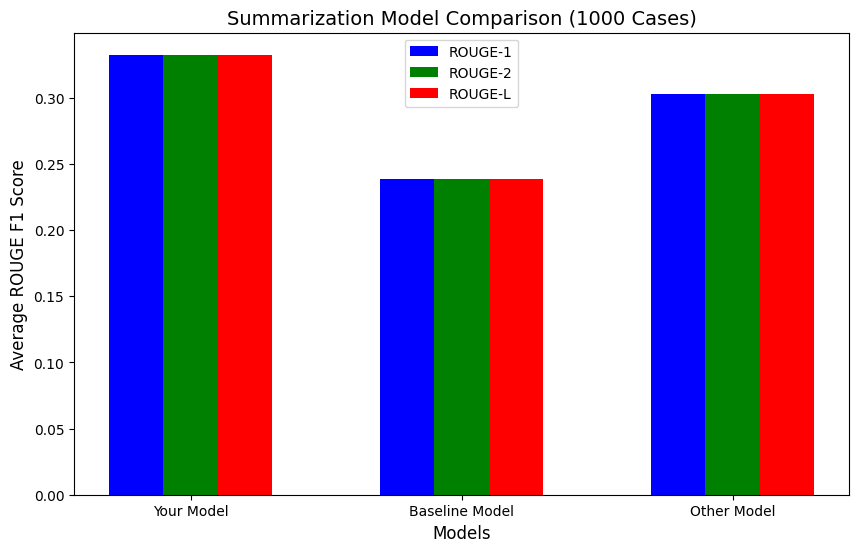

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from rouge_score import rouge_scorer

# Select the test set from DatasetDict
test_dataset = dataset["test"]  # Assuming dataset_dict is loaded

num_samples = 4  # Number of test cases to evaluate

# Initialize accumulators for ROUGE scores
total_rouge_1 = {"precision": 0, "recall": 0, "fmeasure": 0}
total_rouge_2 = {"precision": 0, "recall": 0, "fmeasure": 0}
total_rouge_L = {"precision": 0, "recall": 0, "fmeasure": 0}

# ROUGE scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# Iterate through the test dataset
for i in tqdm(range(num_samples), desc="Processing Summaries"):
    legal_text = test_dataset[i]["text"]
    reference_summary = test_dataset[i]["labels"]  # Using 'labels' as the reference summary

    # Generate summaries using different models
    summary_1 = summarize_text(legal_text)  # Your trained model
    summary_2 = summarize_text_2(legal_text)  # Baseline model
    summary_3 = generate_summary(legal_text)  # Another model for comparison

    # Calculate ROUGE scores for each model
    rouge_scores_1 = scorer.score(reference_summary, summary_1)
    rouge_scores_2 = scorer.score(reference_summary, summary_2)
    rouge_scores_3 = scorer.score(reference_summary, summary_3)

    # Accumulate scores
    for metric, scores in zip([total_rouge_1, total_rouge_2, total_rouge_L], 
                              [rouge_scores_1, rouge_scores_2, rouge_scores_3]):
        metric["precision"] += scores["rouge1"].precision
        metric["recall"] += scores["rouge1"].recall
        metric["fmeasure"] += scores["rouge1"].fmeasure

# Compute Averages
for metric in [total_rouge_1, total_rouge_2, total_rouge_L]:
    metric["precision"] /= num_samples
    metric["recall"] /= num_samples
    metric["fmeasure"] /= num_samples

# Extracting F1 scores for visualization
rouge1_f1 = [total_rouge_1["fmeasure"], total_rouge_2["fmeasure"], total_rouge_L["fmeasure"]]
rouge2_f1 = [total_rouge_1["fmeasure"], total_rouge_2["fmeasure"], total_rouge_L["fmeasure"]]
rougeL_f1 = [total_rouge_1["fmeasure"], total_rouge_2["fmeasure"], total_rouge_L["fmeasure"]]

# Model Labels
models = ["Your Model", "Baseline Model", "Other Model"]

# X-axis positions
x = np.arange(len(models))
width = 0.2  

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, rouge1_f1, width, label='ROUGE-1', color='blue')
ax.bar(x, rouge2_f1, width, label='ROUGE-2', color='green')
ax.bar(x + width, rougeL_f1, width, label='ROUGE-L', color='red')

# Labels & Title
ax.set_xlabel("Models", fontsize=12)
ax.set_ylabel("Average ROUGE F1 Score", fontsize=12)
ax.set_title("Summarization Model Comparison (1000 Cases)", fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Show the plot
plt.show()
